# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os

from pyspark.sql import SparkSession;
from pyspark.sql.functions import regexp_replace, month, from_unixtime, to_timestamp, lead, datediff, to_date, mean, avg, isnan, countDistinct, count,when,col, concat, desc, explode, lit, min, max, split, udf, isnull;
from pyspark.sql.types import IntegerType;

from pyspark.ml.feature import RegexTokenizer, MinMaxScaler, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, GBTClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

import re;
import datetime;

import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
import numpy as np;
from itertools import cycle, islice;

In [2]:
# create a Spark session
spark = SparkSession\
                    .builder\
                    .master('local')\
                    .appName("Sparkify Project")\
                    .getOrCreate();

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load data "mini_sparkify_event_data.json"
df = spark.read.json('mini_sparkify_event_data.json');

#see top records in dataset
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
print(df.take(5));

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Ba

In [6]:
#lets look at shema of data :
df.printSchema();

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# number of rows in the dataframe
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))
print("columns Present in data set in the dataframe{}".format(df.columns));

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18
columns Present in data set in the dataframe['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [8]:
# drop any cells with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [9]:
# drop any cell that has an empty string in userId
df = df[df.userId != ""]
df.count()

278154

In [10]:
#discribing all the columns in dataframe
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,278154,None,None,Cancelled,Logged In
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,278154,114.89918174824018,129.851729399489,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,278154,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


After cleaning the dataset, we now checking for invalid or missing data. To illustrate, records without userids or session id's

In [11]:
# check null values in columns(userId and sessionId has none)
df.toPandas().isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

In [12]:
# sum all null items
df.toPandas().isnull().sum().sum()

150138

In [13]:
# inspect userId column for the first 20 columns
df.select('userId').dropDuplicates().sort('userId').show(20)


+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [14]:
# change the original timestamp in the dataset to the common format
get_time = udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts)).withColumn('registration_time',get_time(df.registration))
df = df.withColumn('month', month(col('time')))
df = df.withColumn('Date', from_unixtime(col('ts')/1000).cast("date"))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn is an event that occurs when a user discontinues a subscription from a business.

## Preliminary Exploratory Data analysis

##### Using page =='Cancellation Confirmation' & auth =='Cancelled' we can deduce our Target Variable ie. if users churn or not

In [15]:
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      10082|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        495|
|            Settings|       1514|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1454|
|             Upgrade|        499|
|               Error|        252|
|      Submit Upgrade|        159|
+--------------------+-----------+



In [16]:
df.select('auth','UserId').groupby('auth').agg({'auth':'count'}).select('auth','count(auth)').show()

+---------+-----------+
|     auth|count(auth)|
+---------+-----------+
|Cancelled|         52|
|Logged In|     278102|
+---------+-----------+



## Observations:

This dataframe groupings above shows the same value counts for cancelled and cancellation confirmation attribute. This is a confirmation that there is no userId with only one factor. Users with cancellation confirmation requests also executed the cancelled feature.

These are good indicators to easily identify churned users. In summary, we could define churned users as those users who have visited the ‘Cancelation Confirmation’ page and also definitely visited 'Cancelled' page. In addition, we could take the ‘Submit Downgrade’ column into consideration.

### Label to caterorize targets(churn or not)



Next, let us define a churn column by using a user defined function which labels all churned users with a 1 and 0 if otherwise:

In [17]:
def label(df):
    """
    Function to create a dataframe containing targets column(0-churn and 1-non-churn) and respective counts
    Input 
    df: spark DataFrame
    Output 
    df : contains labelled targets with the churn column
    """
   
    label_df=df.withColumn('churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0)).\
                            groupBy('userId').agg(Fsum('churn').alias('churn'))
    print(label_df.groupBy('churn').count().show())
    churned_rate = label_df.select(avg("churn")).collect()[0]["avg(churn)"]
    print(f"percentage churn: {churned_rate * 100:,.2f}%")

    df = df.join(label_df, on='userId')
    return df

In [18]:
df = label(df)

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+

None
percentage churn: 23.11%


## Analyzing users that stayed versus users that churned using certain features

In [19]:
#Exploratory Data Analysis using various columns
def exploratory_data_analysis(df,col_name):
    """
    prints countplot of input col
    Input 
    df: spark DataFrame
    col_name : the column with counted values
    Output :
    None
    
    """
    pd = df.select(["userId", col_name, "churn"]).toPandas()
    sns.countplot(x=col_name, hue="churn", data=pd);

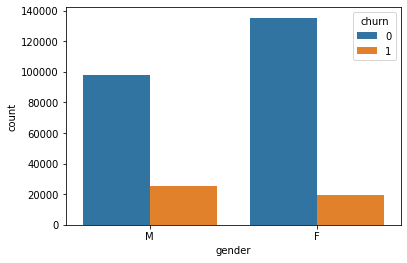

In [20]:
# exploratory data analysis per gender
exploratory_data_analysis(df,"gender")

##### From the visulaization above more male users churn than female users

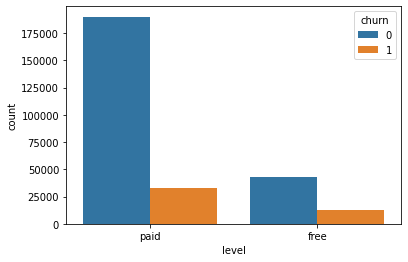

In [21]:
# exploratory data analysis per level
exploratory_data_analysis(df,"level")

##### From the visualization above users that paid for the services have higher churn rate than users that access services for free

In [22]:
# location name too long;  extract states from its respective location
df = df.withColumn("location", regexp_replace("location", '[^a-zA-Z0-9\,\-]', ''))\
        .withColumn('location', split(col('location'),',').getItem(1))
df.select('location').show(n=10)

+--------+
|location|
+--------+
|      CA|
|   MA-NH|
|      CA|
|   MA-NH|
|      CA|
|   MA-NH|
|   MA-NH|
|      CA|
|      CA|
|      CA|
+--------+
only showing top 10 rows



<AxesSubplot:xlabel='location'>

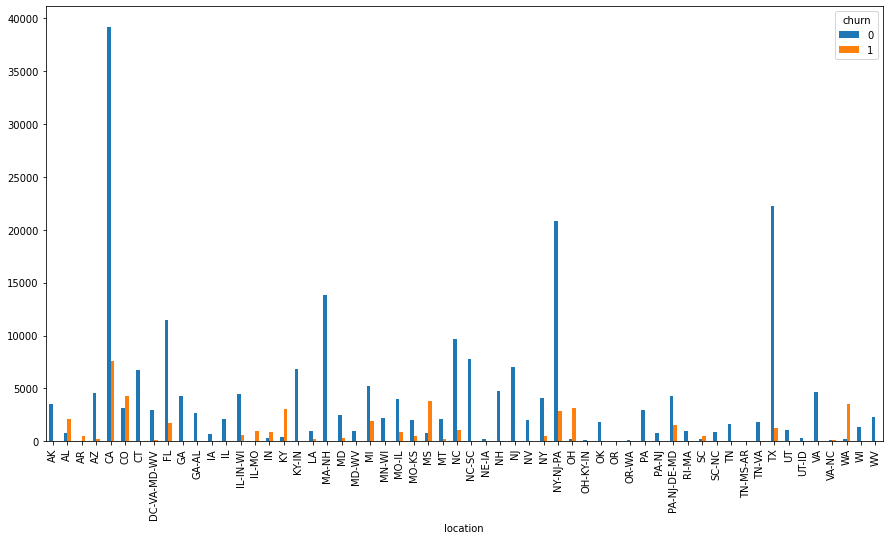

In [23]:
# exploratory data analysis per location
df_state_count= df.select('userId','location','churn').groupby('location','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count.pivot(index='location', columns='churn', values='count').plot(kind='bar', ax=ax)

##### From the visulization above, some locations have churned users while others have no churned users at all.

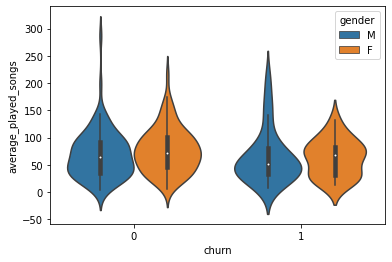

In [24]:
# Lets visualize the gender distribution for number of songs played per session for churned and active users
total_songs_df = df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'average_played_songs').toPandas()

ax = sns.violinplot('churn', y = 'average_played_songs', hue = 'gender', data = total_songs_df)



###### From the visualization above, we can clearly observe that the churned users played less number of songs per session when compared to active users 

<AxesSubplot:xlabel='count', ylabel='churn'>

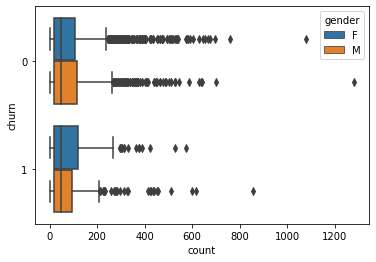

In [25]:
# Let's visualize the gender distribution for total number of operations per session between normal and churned users
df_ops = df.groupby("churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'churn', orient = 'horizontal', data = df_ops, hue = 'gender')

###### From the visualization above, we can clearly observe that churned users performed lesser number of operations compared to active users. Also male users display higher churn rate than female users.

###  "Submit Downgrade" is an indicator for Users Churn or not.¶

In [26]:
#EDA using downgrade events
df.filter((col('page')=='Downgrade')&(col('churn')==1)).select('userId').distinct().count()

35

##### Out of the 52 churned users 35 downgraded their service

In [27]:
df.filter((col('page')=='Submit Downgrade')&(col('churn')==1)).select('userId').distinct().count()

9

##### Now, observing the submit downgrade feature, only  9 users submitted downgrade out of 52 churned users. This is an indicator that active users submits service downgrade than churned users.

In [28]:
df.filter((col('page')=='Submit Downgrade')&(col('churn')==0)).select('userId').distinct().count()

40

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
# Add target to find active(0) vs churned users(1) 
target = df.groupBy("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

target.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
|   155|    0|
|   132|    0|
|   154|    0|
|100014|    1|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|    29|    1|
|    69|    0|
|100021|    1|
|    42|    0|
+------+-----+
only showing top 20 rows



In [30]:
# Feature one: Add count artist feature to obtain the number of artist each user listened to
df_artist = df.groupby("userId") \
                                    .agg(countDistinct("artist")) \
                                    .withColumnRenamed("count(artist)", "artist_count")
feat_one = target.join(df_artist,["userId"])
feat_one.show()

+------+-----+------------+
|userId|churn|artist_count|
+------+-----+------------+
|100010|    0|         252|
|200002|    0|         339|
|   125|    1|           8|
|   124|    0|        2232|
|    51|    1|        1385|
|     7|    0|         142|
|    15|    0|        1302|
|    54|    1|        1744|
|   155|    0|         643|
|100014|    1|         233|
|   132|    0|        1299|
|   154|    0|          78|
|   101|    1|        1241|
|    11|    0|         534|
|   138|    0|        1332|
|300017|    0|        2070|
|100021|    1|         207|
|    29|    1|        1804|
|    69|    0|         865|
|   112|    0|         195|
+------+-----+------------+
only showing top 20 rows



In [31]:
# Feature two: Count the number of visit made by each user to the app using the total number of times a userId is there in df
df_visits = df.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count")
feat_two = feat_one.join(df_visits,["userId"])
feat_two.show()

+------+-----+------------+-----------+
|userId|churn|artist_count|visit_count|
+------+-----+------------+-----------+
|100010|    0|         252|        381|
|200002|    0|         339|        474|
|   125|    1|           8|         11|
|   124|    0|        2232|       4825|
|    51|    1|        1385|       2464|
|     7|    0|         142|        201|
|    15|    0|        1302|       2278|
|    54|    1|        1744|       3437|
|   155|    0|         643|       1002|
|100014|    1|         233|        310|
|   132|    0|        1299|       2304|
|   154|    0|          78|        118|
|   101|    1|        1241|       2149|
|    11|    0|         534|        848|
|   138|    0|        1332|       2469|
|300017|    0|        2070|       4428|
|100021|    1|         207|        319|
|    29|    1|        1804|       3603|
|    69|    0|         865|       1342|
|   112|    0|         195|        292|
+------+-----+------------+-----------+
only showing top 20 rows



In [32]:
# Feature three: Calculate the number of unique songs a user listens to 
df_count_songs = df.groupby("userId")\
                                    .agg(countDistinct("song"))\
                                    .withColumnRenamed("count(song)", "song_count")
feat_three = feat_two.join(df_count_songs,["userId"])
feat_three.show()

+------+-----+------------+-----------+----------+
|userId|churn|artist_count|visit_count|song_count|
+------+-----+------------+-----------+----------+
|100010|    0|         252|        381|       269|
|200002|    0|         339|        474|       378|
|   125|    1|           8|         11|         8|
|   124|    0|        2232|       4825|      3339|
|    51|    1|        1385|       2464|      1854|
|     7|    0|         142|        201|       148|
|    15|    0|        1302|       2278|      1707|
|    54|    1|        1744|       3437|      2414|
|   155|    0|         643|       1002|       759|
|100014|    1|         233|        310|       248|
|   132|    0|        1299|       2304|      1718|
|   154|    0|          78|        118|        83|
|   101|    1|        1241|       2149|      1608|
|    11|    0|         534|        848|       616|
|   138|    0|        1332|       2469|      1791|
|300017|    0|        2070|       4428|      3013|
|100021|    1|         207|    

In [33]:
#Feature four: Calculate total length associated with each user
df_length = df.groupby("userId")\
                            .agg({"length" : "sum"})\
                               .withColumnRenamed("sum(length)","total_length")
feat_four = feat_three.join(df_length,["userId"])
feat_four.show()

+------+-----+------------+-----------+----------+------------------+
|userId|churn|artist_count|visit_count|song_count|      total_length|
+------+-----+------------+-----------+----------+------------------+
|100010|    0|         252|        381|       269| 66940.89735000003|
|200002|    0|         339|        474|       378| 94008.87593999993|
|   125|    1|           8|         11|         8|2089.1131000000005|
|   124|    0|        2232|       4825|      3339|1012312.0927899999|
|    51|    1|        1385|       2464|      1854| 523275.8428000004|
|     7|    0|         142|        201|       148| 38034.08710000002|
|    15|    0|        1302|       2278|      1707|477307.60581000015|
|    54|    1|        1744|       3437|      2414| 711344.9195400011|
|   155|    0|         643|       1002|       759|       198779.2919|
|100014|    1|         233|        310|       248| 67703.47208000004|
|   132|    0|        1299|       2304|      1718| 483118.9038399997|
|   154|    0|      

In [34]:
#Feature five: Obtain time related features

#Sub-feature 1. Registered days i.e time between day of registration and now
user_time=df.groupBy('userId','registration_time').agg(min('time'),max('time'))
user_time=user_time.select('userId','registration_time',
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

#Sub-Feature 2.Days between last day for a user and last day in df
user_time=user_time.withColumn('registered_days',datediff('last_time','first_time')).withColumn(
    'last_recent',datediff(to_date(lit("2018-12-03")),'last_time')) #(2018-12-03) is the last date in the dataframe
user_time=user_time.select('userId','registered_days','last_recent')

feat_five=feat_four.join(user_time, ['userId'])
feat_five.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|
+------+-----+------------+-----------+----------+------------------+---------------+-----------+
|100010|    0|         252|        381|       269| 66940.89735000003|             44|         12|
|200002|    0|         339|        474|       378| 94008.87593999993|             45|         18|
|   125|    1|           8|         11|         8|2089.1131000000005|              0|         52|
|   124|    0|        2232|       4825|      3339|1012312.0927899999|             60|          3|
|    51|    1|        1385|       2464|      1854| 523275.8428000004|             16|         47|
|     7|    0|         142|        201|       148| 38034.08710000002|             51|         10|
|    15|    0|        1302|       2278|      1707|477307.60581000015|             55|          8|
|    54|    1|      

In [35]:
# Feature six: Identify gender with 0 for Male and 1 for Female
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
user_gender = df.withColumn("gender", flag_gender("gender"))
user_gender = user_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
feat_six=feat_five.join(user_gender, ['userId'])
feat_six.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|gender|
+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+
|100010|    0|         252|        381|       269| 66940.89735000003|             44|         12|     1|
|200002|    0|         339|        474|       378| 94008.87593999993|             45|         18|     0|
|   125|    1|           8|         11|         8|2089.1131000000005|              0|         52|     0|
|   124|    0|        2232|       4825|      3339|1012312.0927899999|             60|          3|     1|
|    51|    1|        1385|       2464|      1854| 523275.8428000004|             16|         47|     0|
|     7|    0|         142|        201|       148| 38034.08710000002|             51|         10|     0|
|    15|    0|        1302|       2278|      1707|47730

In [36]:
# Feature seven: Identify level of users with 0 for Free and 1 for paid
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
user_level = df.withColumn("level", flag_level("level"))
user_level = user_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
feat_seven=feat_six.join(user_level, ['userId'])
feat_seven.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|gender|level|
+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+
|100010|    0|         252|        381|       269| 66940.89735000003|             44|         12|     1|    0|
|200002|    0|         339|        474|       378| 94008.87593999993|             45|         18|     0|    1|
|   125|    1|           8|         11|         8|2089.1131000000005|              0|         52|     0|    0|
|   124|    0|        2232|       4825|      3339|1012312.0927899999|             60|          3|     1|    1|
|    51|    1|        1385|       2464|      1854| 523275.8428000004|             16|         47|     0|    1|
|     7|    0|         142|        201|       148| 38034.08710000002|             51|         10|     0|    0|
|

In [37]:
#Feature eight: Calculate on avg. the number of items a user listens to on a daily basis
daily_item_df = df.groupby('userId','date').agg(max('itemInSession')).\
                    groupBy('userId').avg('max(itemInSession)').\
                    withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
feat_eight = feat_seven.join(daily_item_df,['userId'])
feat_eight.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+------------------+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|gender|level|   avg_daily_items|
+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+------------------+
|100010|    0|         252|        381|       269| 66940.89735000003|             44|         12|     1|    0| 54.42857142857143|
|200002|    0|         339|        474|       378| 94008.87593999993|             45|         18|     0|    1|            84.375|
|   125|    1|           8|         11|         8|2089.1131000000005|              0|         52|     0|    0|              10.0|
|   124|    0|        2232|       4825|      3339|1012312.0927899999|             60|          3|     1|    1|198.80555555555554|
|    51|    1|        1385|       2464|      1854| 523275.8428000004|             16|     

In [38]:
# feature nine: Add two session related features plus number of unique unique sessions of each user

# calculate number of sessions of each user
user_session = df.groupby("userId").agg(countDistinct('sessionId'))


# Sub-feature 1 - calculate time of each session
user_session_time=df.groupBy('userId','sessionId').agg(min('time'),max('time')).orderBy('userId','sessionId')
user_session_time=user_session_time.select('userId','sessionId',
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

user_session_time=user_session_time.withColumn('session_duration_mins',(col("last_time").cast("long") - col("first_time")\
                                                                            .cast("long"))/60)

# Sub-feature 2 - calculate gap time of each pair of close sessions 

user_session_time=user_session_time.withColumn('next_session_start_time',lead(user_session_time['first_time'])
                                 .over(Window.partitionBy("userId").orderBy('sessionId')))    

user_session_time=user_session_time.withColumn('gap_time',datediff('next_session_start_time','first_time'))

# aggregate these two features; session duration of users in minutes and average gap time in days of users
user_session_time=user_session_time.groupBy('userId').agg(mean('session_duration_mins').alias('avg_session_duration_mins'),
                                           mean('gap_time').alias('avg_gap_time_days')).fillna(0)


#merge with user dataframe
df_session=user_session_time.join(user_session,["userId"])
feat_nine = feat_eight.join(user_session_time,["userId"])
feat_nine.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+------------------+-------------------------+------------------+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|gender|level|   avg_daily_items|avg_session_duration_mins| avg_gap_time_days|
+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+------------------+-------------------------+------------------+
|100010|    0|         252|        381|       269| 66940.89735000003|             44|         12|     1|    0| 54.42857142857143|       154.48333333333332| 7.333333333333333|
|200002|    0|         339|        474|       378| 94008.87593999993|             45|         18|     0|    1|            84.375|                    266.4|               9.0|
|   125|    1|           8|         11|         8|2089.1131000000005|              0|         52|     0|    0|              1

In [39]:
# feature ten: Add page view related features: calculate number of visited pages by users excluding Cancellation Confirmation and Cancel pages
# the features are 17 in number
df_page_view=df.groupBy('userId').pivot('page').count()
df_page_view=df_page_view.na.fill(0).drop('Cancellation Confirmation','Cancel')

df_page_totalview=df.filter("page != 'Cancellation Confirmation' and page != 'Cancel'" ).groupBy('userId').count()

# convert actual number of visited pages to percentage 
df_page_view=df_page_view.join(df_page_totalview,['userId'])
columns=df_page_view.columns
columns=[column for column in columns if column not in ('userId', 'count')]

for colName in columns:
    df_page_view = df_page_view.withColumn(colName, col(colName)/col('count'))

overall_data = feat_nine.join(df_page_view,["userId"])
overall_data.show()

+------+-----+------------+-----------+----------+------------------+---------------+-----------+------+-----+------------------+-------------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|userId|churn|artist_count|visit_count|song_count|      total_length|registered_days|last_recent|gender|level|   avg_daily_items|avg_session_duration_mins| avg_gap_time_days|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgrade|      Submit Upgrad

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [40]:
overall_data = overall_data.drop("userId") #we do not need userId for modelling
feature_columns = [col for col in overall_data.columns if col!='churn'] #feature columns don't include churn as that is the target

In [41]:
overall_data.printSchema()


root
 |-- churn: long (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- visit_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- total_length: double (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- last_recent: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- avg_daily_items: double (nullable = true)
 |-- avg_session_duration_mins: double (nullable = false)
 |-- avg_gap_time_days: double (nullable = false)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (n

In [42]:
pd_features = overall_data.drop("churn").toPandas()


/Users/AkandeImisioluwa/Documents/Sparkify-Churn-Detector/sparkify-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


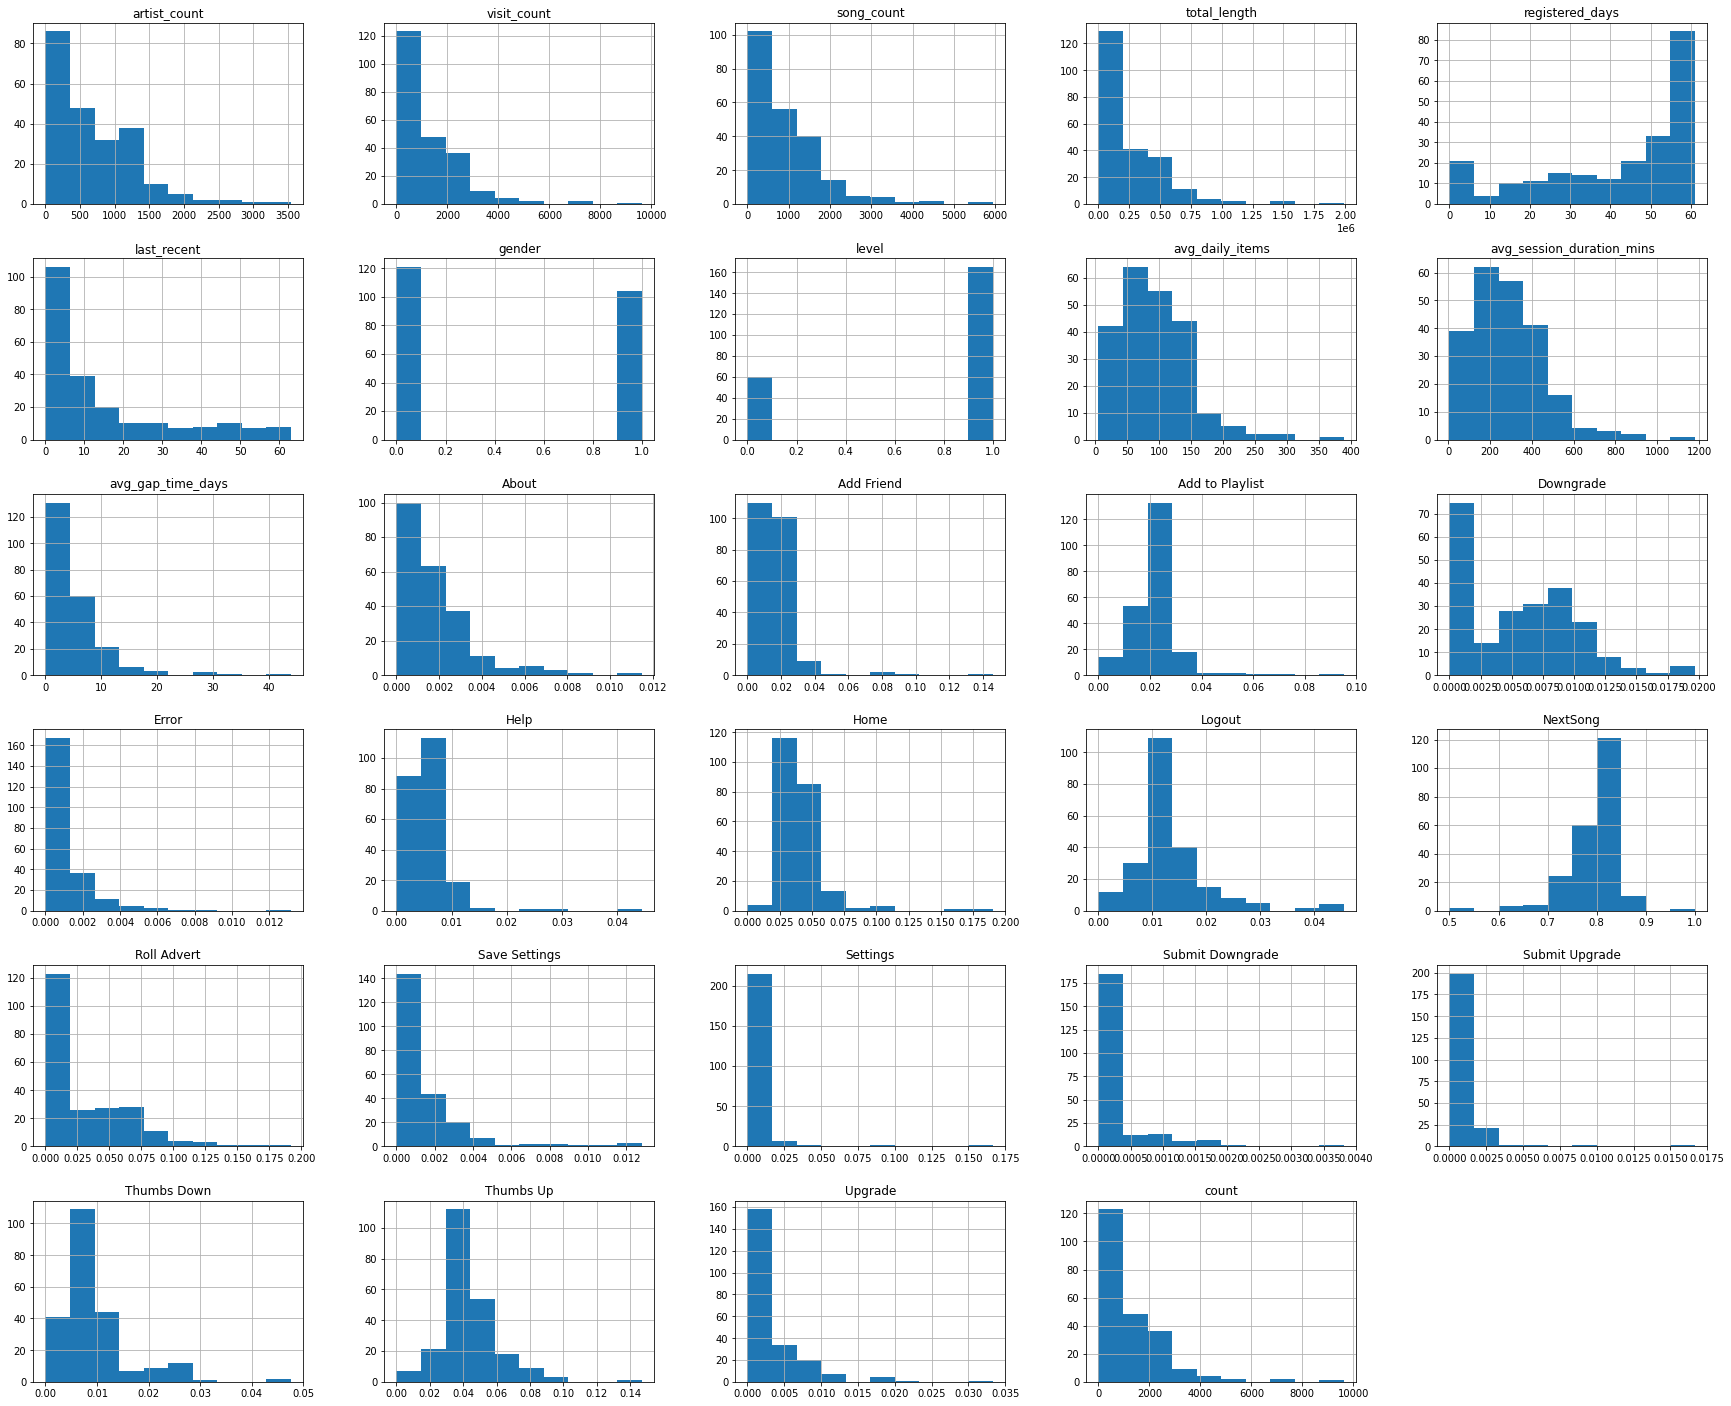

In [43]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = pd_features.hist(ax=ax)

In [44]:
train, test = overall_data.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [45]:
def build_model(classifier, param):
    """
    Builds a model based on the inputs
    Input:
    classifier - type of classifier
    param - built param grid
    Output :
    model - ML pipeline model
    """
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

#### Logistic Regression

In [46]:
# Approach 1 : Logistic Regression Classifier
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
lr_param = ParamGridBuilder().build()
lr_model = build_model(lr, lr_param)

In [47]:
%%time
lr_fit_model = lr_model.fit(train)

CPU times: user 4.66 s, sys: 1.63 s, total: 6.29 s
Wall time: 18min 15s


In [48]:
lr_pred = lr_fit_model.transform(test)

In [49]:
lr_pred.select("prediction").dropDuplicates().collect()


[Row(prediction=0.0), Row(prediction=1.0)]

In [50]:
# Obtain different evaluation metrics for Logistic Regression
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
print("The metrics for the Logistic Regression Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(lr_pred, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(lr_pred, {evaluator.metricName : "accuracy"})))

The metrics for the Logistic Regression Classifier are as follows :
The F-1 Score is 0.8537815126050421
The accuracy is 0.85


#### Random Forest Classifier

In [51]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [52]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 1 s, sys: 456 ms, total: 1.46 s
Wall time: 2min 53s


In [53]:
rf_pred = rf_fit_model.transform(test)

In [54]:
# Obtain different evaluation metrics for Random Forest

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol="churn")
print("The metrics for our Random Forest Classifier are as follows :")
print("The accuracy is {}".format(evaluator.evaluate(rf_pred, {evaluator.metricName : "accuracy"})))
print("The F-1 Score is {}".format(evaluator.evaluate(rf_pred, {evaluator.metricName : "f1"})))

The metrics for our Random Forest Classifier are as follows :
The accuracy is 0.85
The F-1 Score is 0.8345263157894737


#### Support Vector Machine Classifier

In [55]:
svm_clf = LinearSVC(featuresCol="scaled_features", labelCol="churn")
svm_clf_param = ParamGridBuilder().build()
svm_clf_model = build_model(svm_clf, svm_clf_param)

In [56]:
%%time
svm_clf_fit_model = svm_clf_model.fit(train)

CPU times: user 1min 1s, sys: 42.4 s, total: 1min 43s
Wall time: 4h 33min 36s


In [57]:
svm_clf_pred = svm_clf_fit_model.transform(test)

In [58]:
# Obtain different evaluation metrics for SVM 

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol="churn")
print("The metrics for our Support Vector Machine classifier are as follows: ")
print("The accuracy is {}".format(evaluator.evaluate(svm_clf_pred, {evaluator.metricName : "accuracy"})))
print("The F-1 Score is {}".format(evaluator.evaluate(svm_clf_pred, {evaluator.metricName : "f1"})))

The metrics for our Support Vector Machine classifier are as follows: 
The accuracy is 0.8333333333333334
The F-1 Score is 0.8250517598343685


#### Gradient Boosted Trees

In [59]:
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [60]:
%%time
gbt_fit_model = gbt_model.fit(train)

CPU times: user 39.5 s, sys: 27.6 s, total: 1min 7s
Wall time: 2h 18min 55s


In [61]:
gbt_pred = gbt_fit_model.transform(test)


In [62]:
# Obtain different evaluation metrics for Gradient Boosted Trees

evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol="churn")
print("The metrics for our Gradient Boosted Trees Classifier are as follows: ")
print("The accuracy is {}".format(evaluator.evaluate(gbt_pred, {evaluator.metricName : "accuracy"})))
print("The F-1 Score is {}".format(evaluator.evaluate(gbt_pred, {evaluator.metricName : "f1"})))

The metrics for our Gradient Boosted Trees Classifier are as follows: 
The accuracy is 0.9
The F-1 Score is 0.8950310559006212


### Model Analysis and improvement using hyperparameter tuning

From the result above comparing the four models used shows the Gradient Boosted classifier performs better with  F1 score of 75% and accuracy of 75% when compared to the remaining three models.

In [114]:
rf_feature_imp = pd.DataFrame({"feature":feature_columns,"importance" : rf_fit_model.bestModel.stages[2].featureImportances})
rf_feature_imp.sort_values(by = "importance",ascending = False).reset_index(drop=True)

,feature,importance
0,last_recent,0.280027
1,registered_days,0.090892
2,avg_gap_time_days,0.079960
3,Thumbs Down,0.077853
4,Thumbs Up,0.049719
5,Downgrade,0.039774
6,NextSong,0.033376
7,artist_count,0.031402
8,Home,0.027294
9,Roll Advert,0.026847


In [115]:
classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")


In [116]:
param_grid_rf = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[15,30]) \
    .addGrid(classifier.numTrees, [30, 80]) \
    .build()

model_tuned = build_model(classifier, param_grid_rf)

In [117]:
%%time
fit_model_tuned = model_tuned.fit(train)

CPU times: user 7.16 s, sys: 3.15 s, total: 10.3 s
Wall time: 19min 4s


In [118]:
best_model = fit_model_tuned.bestModel


In [119]:
best_model_pred = best_model.transform(test)


In [120]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol="churn")

best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy))

f1 using tuned RF: 0.8499999999999999
accuracy using tuned RF: 0.8666666666666667


In [121]:
rf_tuned_feature_imp = pd.DataFrame({"feature":feature_columns,"importance" : best_model.stages[2].featureImportances})
rf_tuned_feature_imp.sort_values(by = "importance",ascending = False).reset_index(drop=True)

,feature,importance
0,last_recent,0.228201
1,registered_days,0.116443
2,avg_gap_time_days,0.071599
3,Thumbs Down,0.061205
4,artist_count,0.050523
5,Thumbs Up,0.037731
6,Settings,0.030702
7,visit_count,0.030648
8,NextSong,0.030302
9,Roll Advert,0.027832


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Conclusion

In this notebook, we have successfully implemented an end to end machine learning project in order to predict customer's churn. Necessary preprocessing activities which include checking for null and duplicate values were performed. A total of 29 features and the target churn label were built for the model. We selected four different models on our data which include Logistic Regression, RandomForest, Support Vector Machines, and Gradient Boosted Trees. We compared the performance of all four models and Random forest outperformed the rest by a large margin in its metrics and time utilized. So we selected it as our final model along with doing some grid search to improve the performance of the model.

### Reccommendation

The models can be improved with a lot more factors, such as adding more data, domain expertise coupled with feature Engineering. Although the volume of data may required tools such as spark to analyze, we can use more data to have better results as the user base grow.

Currently, we have about 223106 records of unique users, and we only use 70% of the data for training. The model has huge potential to improve in performance if the sample data size increases. That said, the model has a huge potential to improve if the sample size increase.

However, due to the fact that the number of churned users, when compared to active users, is smaller, we employed F1 score and accuracy as the metric for optimization.

### Reflections

This project given exposure to Apache spark environment which is typically used to analyze big data applications. Customer churn is a vital factor needed to be monitored by every company in order to determine how well they are doing in their businesses. The ability to early detect customers with high probability of churning will save the company a whole lot of cost.

One of the interesting but challenging part of the project is identifying the features that are responsible for for a customer churn or not. Identifying and selecting relevant features are vital to a good model and can be challenging at times. The exploratory data analysis play important role in this process. Another interesting part of the project is training the classifiers, classifiers comparison and fine tuning parameters.

Generally, Music companies such as this can reduce customers churn by looking inwards to primary causes of churn over certain period of time. Events such as attracting targetted users with promotional offers for instance new users or persistent users, lower subscription price during festival periods, improve user experience and interaction on the music application at intervals can be practiced to reduce churn rate to the bearest minimum.  